In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score
import graphviz 
import itertools

In [2]:
# function use to plot the confusion matrix
def plot_cm(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Preprocessing functions
Here are a couple of preprocessing function used to transform the data we load

In [3]:
def remove_slash_name(_df):
    df = _df.copy()
    df['Player'] = df['Player'].apply(lambda row: row.split('\\')[0])
    return df

def remove_rk(_df):
    df = _df.copy()
    return df.drop(['Rk'], axis=1)

def remove_team(_df):
    df = _df.copy()
    return df.drop(['Tm'], axis=1)

def remove_age(_df):
    df = _df.copy()
    return df.drop(['Age'], axis=1)

def remove_game(_df):
    df = _df.copy()
    return df.drop(['G'], axis=1)   

def remove_game_started(_df):
    df = _df.copy()
    return df.drop(['GS'], axis=1)   

def remove_min(_df):
    df = _df.copy()
    return df.drop(['MP'], axis=1)    

def extract_name_position(_df):
    df = _df.copy()
    return _df.drop(['Pos','Player'], axis=1), _df[['Player', 'Pos']]
    

def remove_nan(_df):
    df = _df.copy()
    return df.dropna(axis=1, how='all').fillna(0)

## Data extraction

In [4]:
# we use pandas to load data directly from csv
df = pd.read_csv('stats_per_game.csv')

# apply a couple of preprocessing function
df = remove_rk(remove_slash_name(df))
df = remove_age(remove_team(df))
df = remove_game(remove_min(df))
df = remove_game_started(df)

unique_pos = np.unique(df['Pos'])
for p in unique_pos:
    print("{} : {} entries".format(p,len(df.loc[df['Pos']==p].index)))

# We can see that only PG, SG, SF, PF and C are relevant as other listed position doesn't have enough entry
pos_used = ['PG','SG','SF','PF','C']
df = df.loc[df['Pos'].isin(pos_used)]

df, pos = extract_name_position(df)
df = remove_nan(df)

C : 120 entries
C-PF : 1 entries
PF : 147 entries
PF-C : 1 entries
PF-SF : 2 entries
PG : 139 entries
SF : 118 entries
SF-SG : 2 entries
SG : 176 entries
SG-PF : 1 entries
SG-SF : 1 entries


## Model creation

In [5]:
le = preprocessing.LabelEncoder()
y = pos['Pos'].values
le.fit(np.unique(y))
y = le.transform(y)

X = df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=int(X.shape[0]/50))
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=14, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Test

0.46320346320346323


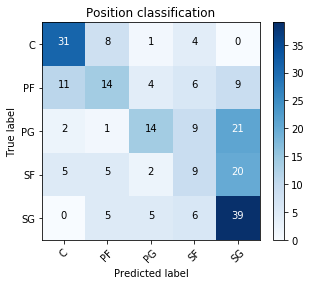

In [6]:
y_pred = clf.predict(X_test)

acc = accuracy_score(y_pred, y_test)
cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

plot_cm(cm, le.classes_, 'Position classification')
print(acc)

## Graph generation

In [7]:
dot_data = tree.export_graphviz(clf, out_file=None,
                               feature_names=df.columns,
                               class_names=le.inverse_transform(range(5)))
graph = graphviz.Source(dot_data)
graph.render(format='png', filename='postition_prediction_graph')

'postition_prediction_graph.png'